In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = ''
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [22]:
sparse.eye(grid**2) * np.random.normal(size=grid**2)

<64x64 sparse matrix of type '<class 'numpy.float64'>'
	with 64 stored elements (1 diagonals) in DIAgonal format>

In [44]:
import scipy.sparse as sparse
import ilupp
import numpy as np
import matplotlib.pyplot as plt 

# plug in any CSR or CSC sparse matrix here
grid = 8
A = sparse.diags([np.random.normal(grid**2)*2, np.random.normal(grid**2)*-1.5, np.random.normal(grid**2), np.random.normal(grid**2)/1.5, np.random.normal(grid**2)*1.1],
                 offsets=[0, 1, -1, grid, -grid],
                 shape=[grid**2]*2
                ).tocsr()
# A = sparse.eye(grid**2) * 4 - sparse.eye(grid**2, k=1) * 2 - sparse.eye(grid**2, k=-1) * 2 - sparse.eye(grid**2, k=grid) * 2 - sparse.eye(grid**2, k=-grid) * 2 
L, U = ilupp.ilu0(A)
# LU1 = ilupp.ILUTPreconditioner(A, fill_in=50)
# L, U = LU1.factors()

b = np.random.normal(size=grid**2)
y = sparse.linalg.spsolve_triangular(L, b, lower=True)
x_approx = sparse.linalg.spsolve_triangular(U, y, lower=False)
x_exact = sparse.linalg.inv(A) @ b

import jax.experimental.sparse as jsparse
from scipy.sparse import csr_matrix, coo_matrix
import os
import jax.numpy as jnp
os.environ["CUDA_VISIBLE_DEVICES"] = ''

In [37]:
from utils import factorsILU

In [38]:
jA = jsparse.BCOO.from_scipy_sparse(A)[None, ...]
jL, jU = factorsILU(jA)
jA1 = jL[0, ...] @ jU[0, ...]

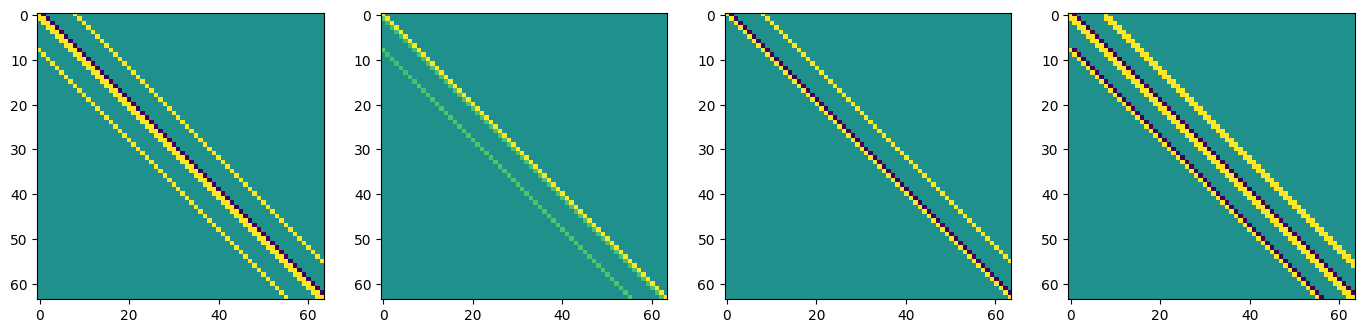

In [39]:
_, axes = plt.subplots(1, 4, figsize=(17,17))
axes[0].imshow(jA.todense().squeeze(), vmin=-1, vmax=1)
axes[1].imshow(jL.todense().squeeze(), vmin=-1, vmax=1)
axes[2].imshow(jU.todense().squeeze(), vmin=-1, vmax=1)
axes[3].imshow((jL[0, ...] @ jU[0, ...]).todense().squeeze(), vmin=-1, vmax=1)

In [46]:
jA_dense = jA[0, ...].todense()
jA1_dense = jA1.todense()

In [51]:
i = 2
jnp.allclose(jA_dense.diagonal(i), jA1_dense.diagonal(i))

Array(True, dtype=bool)

In [17]:
jA1.todense()

Array([[ 4.      , -2.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-2.      ,  4.      , -2.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , -2.      ,  4.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  4.      , -2.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ..., -2.      ,  4.      ,
        -2.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      , -2.      ,
         3.999999]], dtype=float32)

In [2]:
A

<64x64 sparse matrix of type '<class 'numpy.float64'>'
	with 302 stored elements in Compressed Sparse Row format>

In [9]:
jA = jsparse.BCOO.from_scipy_sparse((A.tocoo()))
jA

BCOO(float32[64, 64], nse=302)

In [12]:
jA.shape

(64, 64)

In [47]:
A_coo = coo_matrix((jA.data, (jA.indices[:, 0], jA.indices[:, 1])), shape=jA.shape).tocsr()
A_csr = A_coo.tocsr()

In [50]:
A_coo

<64x64 sparse matrix of type '<class 'numpy.float32'>'
	with 302 stored elements in COOrdinate format>

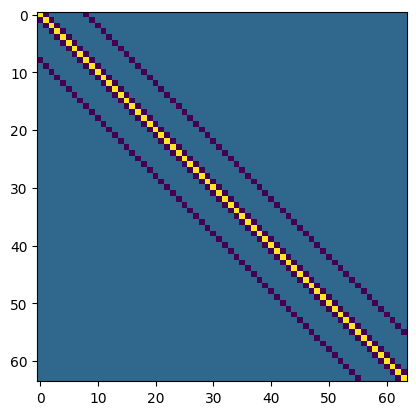

In [52]:
plt.imshow(A_csr.todense())

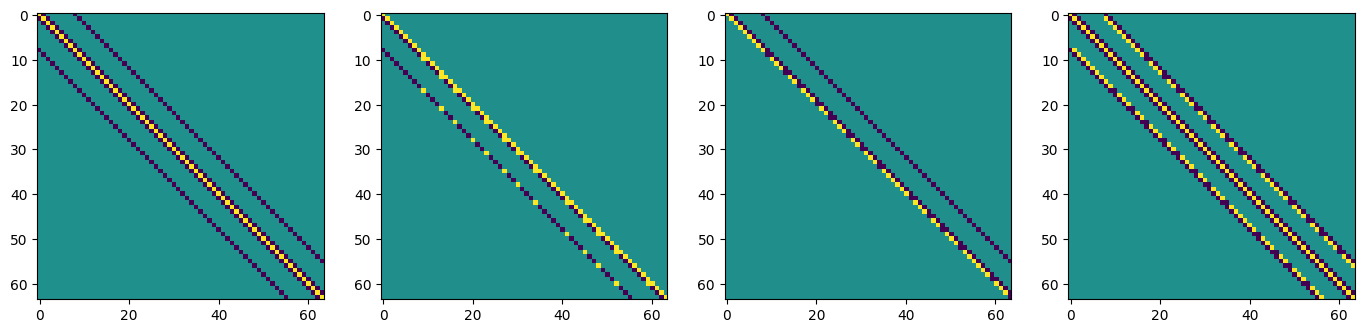

In [124]:
_, axes = plt.subplots(1, 4, figsize=(17,17))
axes[0].imshow(A.todense()*100, vmin=-1, vmax=1)
axes[1].imshow(L.todense()*100, vmin=-1, vmax=1)
axes[2].imshow(U.todense()*100, vmin=-1, vmax=1)
axes[3].imshow((L@U).todense()*100, vmin=-1, vmax=1)

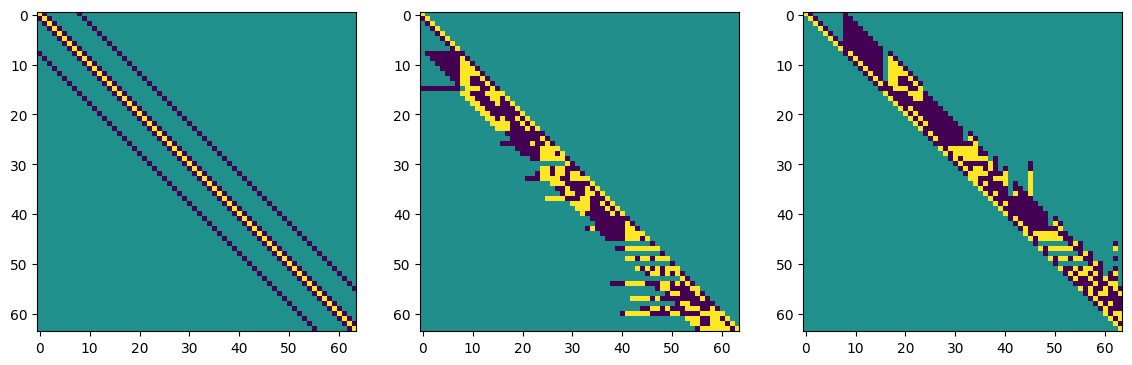

In [117]:
lu, _ = scipy.linalg.lu_factor(A.todense())
_, axes = plt.subplots(1, 3, figsize=(14,14))
axes[0].imshow(A.todense()*100, vmin=-1, vmax=1)
axes[1].imshow(np.tril(lu)*1000, vmin=-1, vmax=1)
axes[2].imshow(np.triu(lu)*1000, vmin=-1, vmax=1)

In [118]:
obj.L @ obj.U

<64x64 sparse matrix of type '<class 'numpy.float64'>'
	with 230 stored elements in Compressed Sparse Column format>

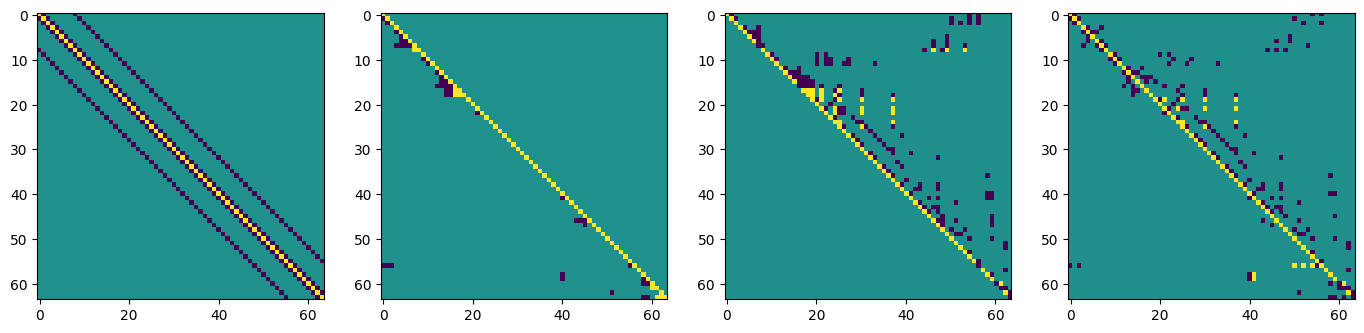

In [43]:
obj = scipy.sparse.linalg.spilu(A, fill_factor=1)
l, u = obj.L, obj.U
_, axes = plt.subplots(1, 4, figsize=(17,17))
axes[0].imshow(A.todense()*100, vmin=-1, vmax=1)
axes[1].imshow(l.todense()*1000, vmin=-1, vmax=1)
axes[2].imshow(u.todense()*1000, vmin=-1, vmax=1)
axes[3].imshow((obj.L @ obj.U).todense()*1000, vmin=-1, vmax=1)

In [128]:
A, B

(<64x64 sparse matrix of type '<class 'numpy.float64'>'
 	with 302 stored elements in Compressed Sparse Row format>,
 <64x64 sparse matrix of type '<class 'numpy.float64'>'
 	with 414 stored elements in Compressed Sparse Row format>)

In [129]:
L, L1

(<64x64 sparse matrix of type '<class 'numpy.float64'>'
 	with 183 stored elements in Compressed Sparse Row format>,
 <64x64 sparse matrix of type '<class 'numpy.float64'>'
 	with 239 stored elements in Compressed Sparse Row format>)

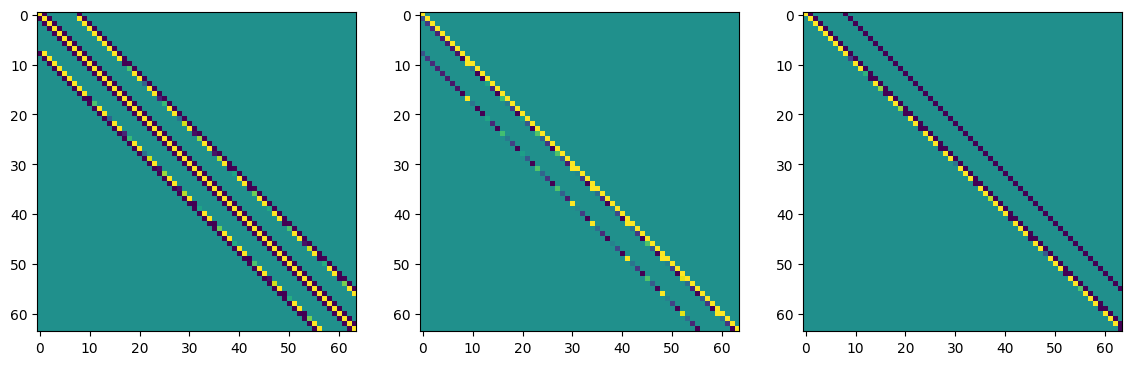

In [125]:
B = L @ U
# B.data = (B.data * 0) + 100
L1, U1 = ilupp.ilu0(B)
_, axes = plt.subplots(1, 3, figsize=(14,14))
axes[0].imshow(B.todense(), vmin=-1, vmax=1)
axes[1].imshow(L1.todense(), vmin=-1, vmax=1)
axes[2].imshow(U1.todense(), vmin=-1, vmax=1)

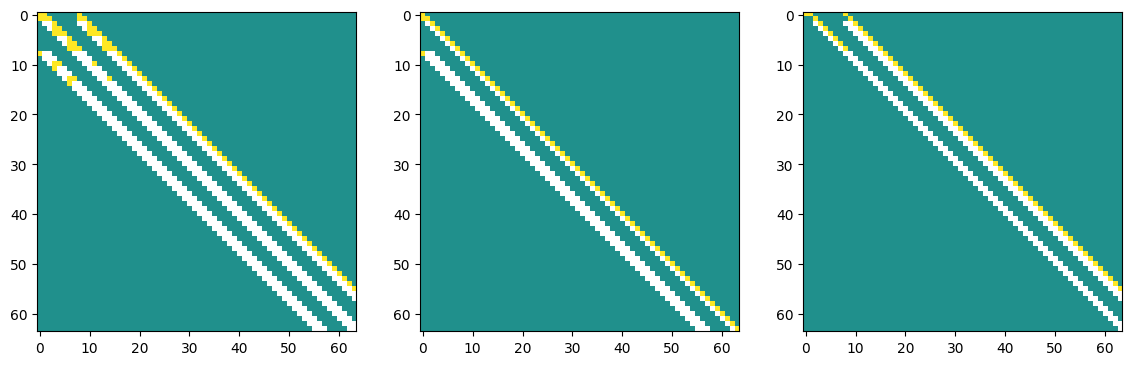

In [120]:
C = L1 @ U1
C.data = (C.data * 0) + 100
L2, U2 = ilupp.ilu0(C)
_, axes = plt.subplots(1, 3, figsize=(14,14))
axes[0].imshow(C.todense()*100, vmin=-1, vmax=1)
axes[1].imshow(L2.todense()*1000, vmin=-1, vmax=1)
axes[2].imshow(U2.todense()*1000, vmin=-1, vmax=1)

In [121]:
D.data.min()

NameError: name 'D' is not defined

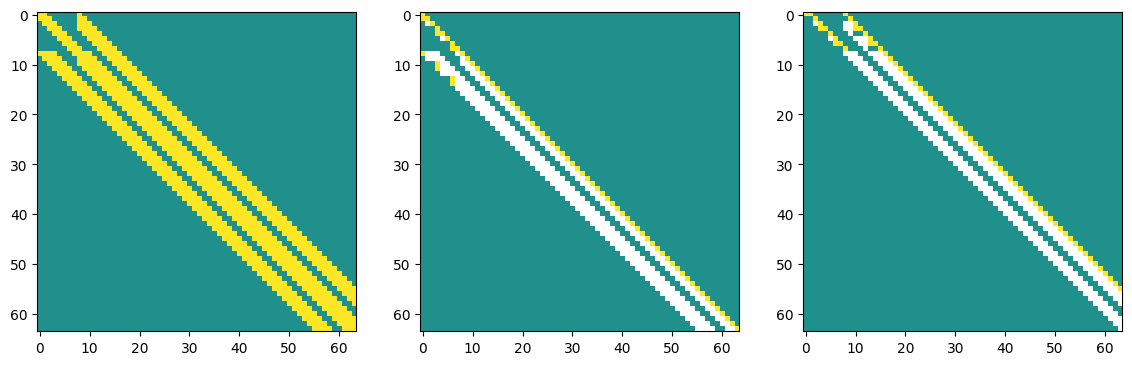

In [194]:
D = L2 @ U2
D.data = np.ones_like(D.data)#(D.data * 0) #+ 100
L3, U3 = ilupp.ilu0(D)
_, axes = plt.subplots(1, 3, figsize=(14,14))
axes[0].imshow(D.todense(), vmin=-1, vmax=1)
axes[1].imshow(L3.todense(), vmin=-1, vmax=1)
axes[2].imshow(U3.todense(), vmin=-1, vmax=1)

In [1]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [2]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches
import numpy as np
from jax.experimental import sparse as jsparse
from jax import device_put

import optax
import matplotlib.pyplot as plt
from functools import partial

from data import dataset_Poisson2D_finite_diff
from conj_grad import ConjGrad, apply_LU
from model import MessagePassing, FullyConnectedNet, PrecNet

from utils import params_count, asses_cond, iter_per_residual, batch_indices
from data import direc_graph_from_linear_system_sparse
from train import train

from scipy.sparse import csc_matrix, coo_matrix, csr_matrix
from scipy.sparse.linalg import spilu

import ilupp

In [3]:
g32 = 32
g64 = 64
N_samples_test = 20

In [4]:
A_test_32, b_test_32, _, _ = dataset_Poisson2D_finite_diff(g32, N_samples_test, seed=43, rhs_distr=[5, 5, 2])
A_test_64, b_test_64, _, _ = dataset_Poisson2D_finite_diff(g64, N_samples_test, seed=43, rhs_distr=[5, 5, 2])

2024-04-02 09:47:18.830230: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
def get_jILU(A, N_samples=N_samples_test):
    ILU_L, ILU_U = [], []
    for i in range(N_samples_test):
        p = ilupp.ILU0Preconditioner(csr_matrix(np.array(A[0, ...].todense(), dtype=np.float64)))
        L, U = p.factors()
        ILU_L.append(jsparse.BCOO.from_scipy_sparse((L.tocoo()))[None, ...])
        ILU_U.append(jsparse.BCOO.from_scipy_sparse((U.tocoo()))[None, ...])

    ILU_L = device_put(jsparse.bcoo_concatenate(ILU_L, dimension=0))
    ILU_U = device_put(jsparse.bcoo_concatenate(ILU_U, dimension=0))
    return ILU_L, ILU_U

In [6]:
L_ilu_32, U_ilu_32 = get_jILU(A_test_32)
L_ilu_64, U_ilu_64 = get_jILU(A_test_64)

In [7]:
llt_g32 = jnp.load('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/results_cases/01-04-20224/llt_g32_b80_e100_lr1e_3.npz')
llt_g64 = jnp.load('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/results_cases/01-04-20224/llt_g64_b32_e150_lr1e_3.npz')
notay_g32 = jnp.load('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/results_cases/01-04-20224/notay_g32_b64_e100_lr5e_4.npz')
notay_g64 = jnp.load('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/results_cases/01-04-20224/notay_g64_b16_e100_lr5e_4.npz')

In [17]:
cond_ILU_32 = jnp.mean(vmap(lambda L, U: jnp.linalg.cond(L @ U), in_axes=(0, 0), out_axes=(0))(L_ilu_32.todense(), U_ilu_32.todense()))
cond_ILU_64 = jnp.mean(vmap(lambda L, U: jnp.linalg.cond(L @ U), in_axes=(0, 0), out_axes=(0))(L_ilu_64.todense(), U_ilu_64.todense()))

In [18]:
print(f"Grid 32x32:\n  cond A: {llt_g32['cond_A']:.0f}, cond LLT loss: {llt_g32['cond_LLT']:.0f}, cond Notay loss: {notay_g32['cond_LLT']:.0f}, cond ILU(0): {cond_ILU_32:.0f}")
print(f"Grid 32x32:\n  cond A: {llt_g64['cond_A']:.0f}, cond LLT loss: {llt_g64['cond_LLT']:.0f}, cond Notay loss: {notay_g64['cond_LLT']:.0f}, cond ILU(0): {cond_ILU_64:.0f}")

Grid 32x32:
  cond A: 441, cond LLT loss: 89, cond Notay loss: 12, cond ILU(0): 14
Grid 32x32:
  cond A: 1712, cond LLT loss: 688, cond Notay loss: 2, cond ILU(0): 15


In [8]:
prec_32 = partial(apply_LU, L=L_ilu_32, U=U_ilu_32)
_, res_ilu_32 = ConjGrad(A_test_32, b_test_32, N_iter=300, prec_func=prec_32, seed=42)

In [9]:
prec_64 = partial(apply_LU, L=L_ilu_64, U=U_ilu_64)
_, res_ilu_64 = ConjGrad(A_test_64, b_test_64, N_iter=300, prec_func=prec_64, seed=42)

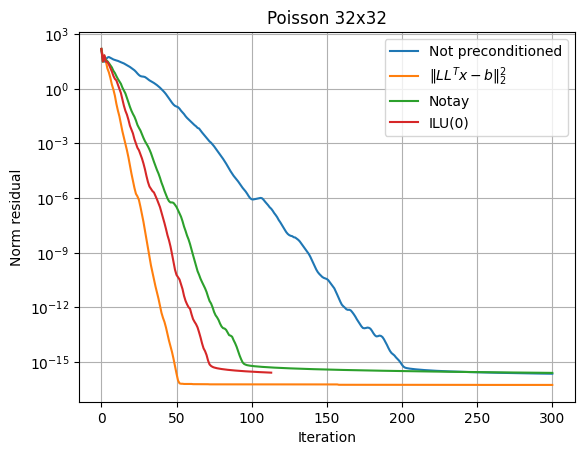

In [10]:
# Plot residuals grid 32
R_I_32 = llt_g32['res_I']
llt_R_LLT_32 = llt_g32['res_LLT']
notay_R_LLT_32 = notay_g32['res_LLT']
ilu_R_32 = jnp.linalg.norm(res_ilu_32, axis=1).mean(0)

plt.plot(range(R_I_32.shape[0]), R_I_32, label='Not preconditioned')
plt.plot(range(llt_R_LLT_32.shape[0]), llt_R_LLT_32, label="$\|LL^Tx - b\|_2^2$")
plt.plot(range(notay_R_LLT_32.shape[0]), notay_R_LLT_32, label="Notay")
plt.plot(range(ilu_R_32.shape[0]), ilu_R_32, label='ILU(0)')

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.yscale('log')
plt.grid()
plt.title('Poisson 32x32')
plt.legend();

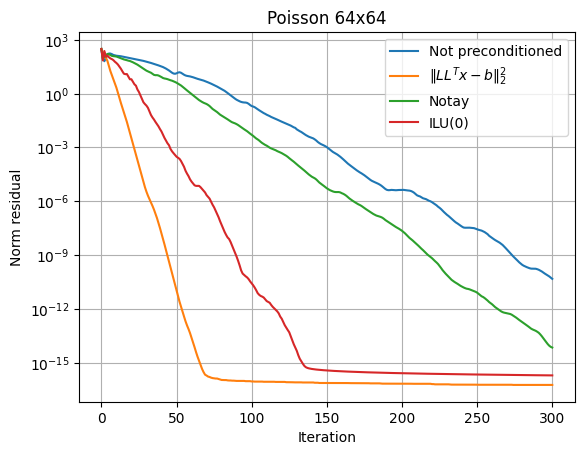

In [11]:
# Plot residuals grid 64
R_I_64 = llt_g64['res_I']
llt_R_LLT_64 = llt_g64['res_LLT']
notay_R_LLT_64 = notay_g64['res_LLT']
ilu_R_64 = jnp.linalg.norm(res_ilu_64, axis=1).mean(0)

plt.plot(range(R_I_64.shape[0]), R_I_64, label='Not preconditioned')
plt.plot(range(llt_R_LLT_64.shape[0]), llt_R_LLT_64, label="$\|LL^Tx - b\|_2^2$")
plt.plot(range(notay_R_LLT_64.shape[0]), notay_R_LLT_64, label="Notay")
plt.plot(range(ilu_R_64.shape[0]), ilu_R_64, label='ILU(0)')

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.yscale('log')
plt.grid()
plt.title('Poisson 64x64')
plt.legend();